In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.optim.optimize import optimize_acqf
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

###########

# pymoo dependencies
import pymoo

from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize

from pymoo.core.problem import Problem as PymooProblem
from pymoo.core.termination import NoTermination

###########

# jmetalpy dependencies
from jmetal.core.problem import FloatProblem
from jmetal.core.solution import FloatSolution
from jmetal.util.termination_criterion import StoppingByEvaluations, TerminationCriterion
from jmetal.util.aggregative_function import Tschebycheff
from jmetal.operator import PolynomialMutation, DifferentialEvolutionCrossover
from jmetal.algorithm.multiobjective.moead import Permutation
from jmetal.algorithm.multiobjective import MOEADIEpsilon


###########

from scipy.stats import qmc
from scipy.stats import gaussian_kde # for density plot

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
def optimize_qnehvi_noconstr(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Pure qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts of raw_samples
                        raw_samples=256,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        
        ##########
        
        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [3]:
def optimize_hybrid_nsga_noconstr(problem, ref_point, initial_x, # must haves
                                  N_BATCH, BATCH_SIZE, 
                                  random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Hybrid qNEHVI + U-NSGA-III")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    pymooproblem = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=0, 
                  xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts of raw_samples
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########

        algorithm = UNSGA3(pop_size=256,
                           ref_dirs=get_reference_directions("energy", problem.n_obj, 256, seed=random_state),
                           sampling=train_x_gp.cpu().numpy(),
                          )

        algorithm.setup(pymooproblem, termination=NoTermination())

        # set the 1st population to the current evaluated population
        pop = algorithm.ask()
        pop.set("F", train_obj_noisy.cpu().numpy())
        algorithm.tell(infills=pop)

        # propose children based on tournament selection -> crossover/mutation
        newpop = algorithm.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)
        
        ##########

        candidates = torch.cat([qnehvi_x, nsga3_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y)
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        new_x =  unnormalize(new_x, bounds=problem.bounds)
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])

        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, qnehvi_x, nsga3_x, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [4]:
def optimize_hybrid_moead_noconstr(problem, ref_point, initial_x, # must haves
                                  N_BATCH, BATCH_SIZE, 
                                  random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Hybrid qNEHVI + MOEAD")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    # define jmetal class
    class jmetalproblem(FloatProblem):

        def __init__(self):
            super(jmetalproblem, self).__init__()
            self.number_of_variables = problem.n_var
            self.number_of_objectives = problem.n_obj

            obj_directions = []
            obj_labels = []

            for i in range(1,problem.n_obj+1):
                obj_directions.append(self.MINIMIZE)
                obj_labels.append(f'f{i}')

            self.obj_directions = obj_directions
            self.obj_labels = obj_labels

            self.lower_bound = [0.0] * problem.n_var
            self.upper_bound = [1.0] * problem.n_var

        def evaluate(self, solution: FloatSolution) -> FloatSolution:
            pass

        def get_name(self):
            return 'jmetalproblem'

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts of raw_samples
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########
        max_pop = train_x_gp.shape[0]
                
        # redefine a new algo at each iteration
        MOEAD_algo = MOEADIEpsilon(problem=jmetalproblem(),
                          population_size=max_pop,
                          crossover=DifferentialEvolutionCrossover(CR=1.0, F=0.5, K=0.5),
                          mutation=PolynomialMutation(probability=1.0 / jmetalproblem().number_of_variables, distribution_index=20),
                          aggregative_function=Tschebycheff(dimension=jmetalproblem().number_of_objectives),
                          neighbor_size=int(max_pop/2),
                          neighbourhood_selection_probability=0.9,
                          max_number_of_replaced_solutions=2,
                          weight_files_path='weights',
                          #termination_criterion=StoppingByEvaluations(BATCH_SIZE),
                         )

        # initialize population
        initial_solutions = []

        for i in range(0, max_pop):
            solution1 = FloatSolution(lower_bound=[0.0] * problem.n_var,
                                      upper_bound=[1.0] * problem.n_var,
                                      number_of_objectives=problem.n_obj,
                                     )
            solution1.variables = train_x_gp[i].cpu().tolist()
            solution1.objectives = train_obj_noisy[i].cpu().tolist()
            
            initial_solutions.append(solution1)

        MOEAD_algo.solutions = initial_solutions

        # perform selection, crossover and mutation to form our offspring population
        MOEAD_algo.permutation = Permutation(max_pop)
        offspring_population = []

        for q in range(256):
            mating_population = MOEAD_algo.selection(MOEAD_algo.solutions)
            offspring = MOEAD_algo.reproduction(mating_population)
            offspring_population.append(offspring[0].variables)
                        
        moead_x = torch.tensor(offspring_population, **tkwargs)        
        
        ##########

        candidates = torch.cat([qnehvi_x, moead_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y)
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        new_x =  unnormalize(new_x, bounds=problem.bounds)
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])

        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, qnehvi_x, moead_x, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [7]:
import joblib

gp_dict = joblib.load('thinfilm_gp_dict')
xscaler = joblib.load('thinfilm_xscaler')
yscaler = joblib.load('thinfilm_yscaler')

lowerbound = torch.tensor([0.0, 0.0, 0.0, 0.0], **tkwargs)
upperbound = torch.tensor([1.0, 1.0, 1.0, 1.0], **tkwargs)

dimensions = 4

class Problem_thinfilm(torch.nn.Module):
    # must define these!
    n_var = 4
    n_obj = 2
    n_constr = 0
    
    ref_point = torch.tensor([1.019, -0.048], **tkwargs) # has to be inverse of outputs, since it gets flipped back later
        
    # input bounds, don't forget to change according to n_var! 
    bounds = torch.vstack([lowerbound,upperbound])
    
    def evaluate(X):
        
        y1 = -X[...,3] # flip
        y2 = gp_dict.predict(X.cpu().numpy())
        y2_tensor = torch.tensor(y2, **tkwargs)
        
        output = torch.stack([y1,y2_tensor], axis=1)
        
        return output
    
initial_x_array = loadtxt("initial_x_10trials4dim_01bounds.csv", delimiter=',')
initial_x_array = initial_x_array.reshape(10, 10, 4)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
# NN dependencies
from torch.utils.data import DataLoader

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import joblib

class Net(nn.Module):
    def __init__(self,n_input_nodes, n_hidden_layers, n_hidden_nodes):
        """
        n_feature : number of input feature nodes
        n_hidden : number of nodes in the hidden layer
        n_output : number of nodes in the output layer
        
        d_hidden : number of hidden layers
        """
        
        super(Net, self).__init__() ## inherit init function from the ancestor
        
        self.input = nn.Linear(n_input_nodes, n_hidden_nodes)
        self.hidden = nn.Linear(n_hidden_nodes, n_hidden_nodes)
        self.predict = nn.Linear(n_hidden_nodes, 1)
        
        self.l_hidden = n_hidden_layers
        
    def forward(self, x):
        x = self.input(x)
        
        for i in range(self.l_hidden):
            x = self.hidden(x)
            x = F.relu(x)
        x = self.predict(x)
        
        return x
    
    def fit(self, x, y, epochs=100):

        optimizer = torch.optim.Adam(self.parameters()) ## SGD gave 'nan'
        loss_func = nn.MSELoss()
      
        for t in range(epochs):

            pred = self.forward(x)     
            loss = loss_func(pred, y)
            optimizer.zero_grad()
            loss.backward()  # backpropagation
            optimizer.step() # update gradient
            
models_tdict = joblib.load('concrete_models_tdict') 
xscaler = joblib.load('concrete_xscaler')
yscaler = joblib.load('concrete_yscaler')

'''
define the problem statement and objective function, using the regressor we previously trained
although there exists tool to infer ref point, we can take origin 0 as a good start
'''
'''
lowerbound1 = []
upperbound1 = []

for i in range(7):
    lowerbound1.append(df.iloc[:,i].min())
    upperbound1.append(df.iloc[:,i].max())

lowerbound = torch.tensor(lowerbound1, **tkwargs)
upperbound = torch.tensor(upperbound1, **tkwargs)
'''
target_dict = {'SL': 'SLUMP(cm)',
               'CS': 'Compressive Strength (28-day)(Mpa)',  
              }


lowerbound = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], **tkwargs)
upperbound = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], **tkwargs)

dimensions = 7

class Problem_concrete(torch.nn.Module):
    # must define these!
    n_var = 7
    n_obj = 2
    
    ref_point = torch.tensor([0, 0], **tkwargs)
        
    # input bounds, don't forget to change according to n_var! 
    bounds = torch.vstack([lowerbound,upperbound])
    
    def evaluate(X):
        n_models = 10
        
        y_pred_top = []
        for i in range(X.shape[0]):
            
            input_x = X[i].float()#.to(device)

            y_pred_list1 = []
            for key in target_dict.keys():

                y_pred_list2 = []
                for i in range(n_models):
                    m = models_tdict['{:}_{:}'.format(key, i)]
                    m.eval()
                    y_pred = m.forward(input_x)
                    y_pred_list2.append(y_pred.detach().cpu().numpy())

                y_pred_list1.append(np.array(y_pred_list2).mean(axis=0))
                
            y_pred_top.append(np.array(y_pred_list1).flatten())
        
        output = torch.tensor(np.array(y_pred_top), **tkwargs)
        
        return output
    
initial_x_array = loadtxt("initial_x_10trials7dim_01bounds.csv", delimiter=',')
initial_x_array = initial_x_array.reshape(10, 16, 7)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
problem = Problem
problemname = "thinfilm"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hvs_qnehvi, hvs_hybrid_nsga, hvs_hybrid_moead = [], [], []
train_qnehvi, train_hybrid_nsga, train_hybrid_moead = [], [], []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)
    
    for algo, hv_list, train_list in zip([optimize_qnehvi_noconstr, optimize_hybrid_nsga_noconstr, optimize_hybrid_moead_noconstr],
                                         [hvs_qnehvi, hvs_hybrid_nsga, hvs_hybrid_moead],
                                         [train_qnehvi, train_hybrid_nsga, train_hybrid_moead]
                                        ):
    
        hv, train = algo(problem, problem.ref_point, initial_x,
                         N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                         random_state=trial, noise=noise, verbose=verbose)
        hv_list.append(hv)
        train_list.append(train)
    

for algo_name, hv_list, train_list in zip(
    ['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
    [hvs_qnehvi, hvs_hybrid_nsga, hvs_hybrid_moead],
    [train_qnehvi, train_hybrid_nsga, train_hybrid_moead]):
    
    savetxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hv_list, delimiter=',')    
    savetxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_list).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem thinfilm with d = 4
Optimizing with Pure qNEHVI


C:\Users\user\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


Batch  1 of 24: Hypervolume = 0.26, time = 3.72s.
Batch  2 of 24: Hypervolume = 0.45, time = 11.97s.
Batch  3 of 24: Hypervolume = 0.50, time = 8.61s.
Batch  4 of 24: Hypervolume = 0.51, time = 10.05s.
Batch  5 of 24: Hypervolume = 0.52, time = 2.24s.
Batch  6 of 24: Hypervolume = 0.53, time = 8.86s.
Batch  7 of 24: Hypervolume = 0.55, time = 15.57s.
Batch  8 of 24: Hypervolume = 0.55, time = 4.77s.
Batch  9 of 24: Hypervolume = 0.55, time = 2.03s.
Batch 10 of 24: Hypervolume = 0.56, time = 3.12s.
Batch 11 of 24: Hypervolume = 0.56, time = 6.09s.
Batch 12 of 24: Hypervolume = 0.56, time = 2.46s.
Batch 13 of 24: Hypervolume = 0.56, time = 1.81s.
Batch 14 of 24: Hypervolume = 0.56, time = 2.44s.
Batch 15 of 24: Hypervolume = 0.56, time = 2.01s.
Batch 16 of 24: Hypervolume = 0.56, time = 11.26s.
Batch 17 of 24: Hypervolume = 0.56, time = 2.50s.
Batch 18 of 24: Hypervolume = 0.56, time = 2.43s.
Batch 19 of 24: Hypervolume = 0.57, time = 4.32s.
Batch 20 of 24: Hypervolume = 0.57, time = 2.5

Batch 11 of 24: Hypervolume = 0.51, time = 16.29s.
Batch 12 of 24: Hypervolume = 0.51, time = 16.25s.
Batch 13 of 24: Hypervolume = 0.51, time = 4.29s.
Batch 14 of 24: Hypervolume = 0.51, time = 2.96s.
Batch 15 of 24: Hypervolume = 0.51, time = 2.41s.
Batch 16 of 24: Hypervolume = 0.51, time = 3.67s.
Batch 17 of 24: Hypervolume = 0.51, time = 2.96s.
Batch 18 of 24: Hypervolume = 0.51, time = 3.72s.
Batch 19 of 24: Hypervolume = 0.51, time = 3.73s.
Batch 20 of 24: Hypervolume = 0.51, time = 3.20s.
Batch 21 of 24: Hypervolume = 0.54, time = 10.31s.
Batch 22 of 24: Hypervolume = 0.54, time = 5.51s.
Batch 23 of 24: Hypervolume = 0.54, time = 4.71s.
Batch 24 of 24: Hypervolume = 0.55, time = 5.17s.
Time taken in total: 189.34s.
Optimizing with Hybrid qNEHVI + U-NSGA-III
Batch  1 of 24: Hypervolume = 0.32, time = 6.18s.
Batch  2 of 24: Hypervolume = 0.41, time = 7.28s.
Batch  3 of 24: Hypervolume = 0.48, time = 13.07s.
Batch  4 of 24: Hypervolume = 0.49, time = 6.49s.
Batch  5 of 24: Hypervo

Batch 21 of 24: Hypervolume = 0.56, time = 3.63s.
Batch 22 of 24: Hypervolume = 0.56, time = 4.41s.
Batch 23 of 24: Hypervolume = 0.56, time = 2.56s.
Batch 24 of 24: Hypervolume = 0.56, time = 2.85s.
Time taken in total: 153.27s.
Optimizing with Hybrid qNEHVI + U-NSGA-III
Batch  1 of 24: Hypervolume = 0.40, time = 7.50s.
Batch  2 of 24: Hypervolume = 0.48, time = 7.23s.
Batch  3 of 24: Hypervolume = 0.53, time = 9.26s.
Batch  4 of 24: Hypervolume = 0.53, time = 9.52s.
Batch  5 of 24: Hypervolume = 0.55, time = 10.91s.
Batch  6 of 24: Hypervolume = 0.56, time = 13.73s.
Batch  7 of 24: Hypervolume = 0.56, time = 6.68s.
Batch  8 of 24: Hypervolume = 0.56, time = 6.61s.
Batch  9 of 24: Hypervolume = 0.57, time = 14.09s.
Batch 10 of 24: Hypervolume = 0.57, time = 8.96s.
Batch 11 of 24: Hypervolume = 0.57, time = 9.74s.
Batch 12 of 24: Hypervolume = 0.57, time = 15.08s.
Batch 13 of 24: Hypervolume = 0.57, time = 8.02s.
Batch 14 of 24: Hypervolume = 0.57, time = 8.66s.
Batch 15 of 24: Hypervo

Batch  6 of 24: Hypervolume = 0.55, time = 7.28s.
Batch  7 of 24: Hypervolume = 0.55, time = 5.44s.
Batch  8 of 24: Hypervolume = 0.56, time = 5.20s.
Batch  9 of 24: Hypervolume = 0.56, time = 5.30s.
Batch 10 of 24: Hypervolume = 0.57, time = 5.43s.
Batch 11 of 24: Hypervolume = 0.57, time = 10.00s.
Batch 12 of 24: Hypervolume = 0.57, time = 5.70s.
Batch 13 of 24: Hypervolume = 0.57, time = 7.94s.
Batch 14 of 24: Hypervolume = 0.57, time = 7.92s.
Batch 15 of 24: Hypervolume = 0.57, time = 8.01s.
Batch 16 of 24: Hypervolume = 0.57, time = 14.46s.
Batch 17 of 24: Hypervolume = 0.57, time = 8.10s.
Batch 18 of 24: Hypervolume = 0.57, time = 6.10s.
Batch 19 of 24: Hypervolume = 0.57, time = 6.66s.
Batch 20 of 24: Hypervolume = 0.57, time = 6.42s.
Batch 21 of 24: Hypervolume = 0.57, time = 7.78s.
Batch 22 of 24: Hypervolume = 0.57, time = 30.38s.
Batch 23 of 24: Hypervolume = 0.58, time = 6.95s.
Batch 24 of 24: Hypervolume = 0.58, time = 6.61s.
Time taken in total: 193.94s.
Optimizing with H

Batch 16 of 24: Hypervolume = 0.57, time = 8.12s.
Batch 17 of 24: Hypervolume = 0.57, time = 11.09s.
Batch 18 of 24: Hypervolume = 0.58, time = 6.88s.
Batch 19 of 24: Hypervolume = 0.58, time = 7.05s.
Batch 20 of 24: Hypervolume = 0.58, time = 10.04s.
Batch 21 of 24: Hypervolume = 0.58, time = 7.93s.
Batch 22 of 24: Hypervolume = 0.58, time = 8.42s.
Batch 23 of 24: Hypervolume = 0.58, time = 9.59s.
Batch 24 of 24: Hypervolume = 0.58, time = 7.95s.
Time taken in total: 183.95s.
Optimizing with Hybrid qNEHVI + MOEAD
Batch  1 of 24: Hypervolume = 0.41, time = 4.37s.
Batch  2 of 24: Hypervolume = 0.52, time = 7.19s.
Batch  3 of 24: Hypervolume = 0.55, time = 9.89s.
Batch  4 of 24: Hypervolume = 0.56, time = 7.16s.
Batch  5 of 24: Hypervolume = 0.56, time = 11.56s.
Batch  6 of 24: Hypervolume = 0.57, time = 8.97s.
Batch  7 of 24: Hypervolume = 0.57, time = 4.89s.
Batch  8 of 24: Hypervolume = 0.57, time = 5.58s.
Batch  9 of 24: Hypervolume = 0.57, time = 9.07s.
Batch 10 of 24: Hypervolume =

In [6]:
problem = Problem
problemname = "thinfilm"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hvs_qnehvi = []
train_qnehvi = []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)
    
    hv, train = optimize_qnehvi_noconstr(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hvs_qnehvi.append(hv)
    train_qnehvi.append(train)
    
    
savetxt(f"{problemname}_hvs_qnehvi_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hvs_qnehvi, delimiter=',')    
savetxt(f"{problemname}_train_qnehvi_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_qnehvi).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem ZDT2 with d = 8
Optimizing with Pure qNEHVI


KeyboardInterrupt: 

In [6]:
problem = Problem_ZDT3
problemname = "ZDT3"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hvs_hybrid_nsga = []
train_hybrid_nsga = []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)
    
    hv, train = optimize_hybrid_nsga_noconstr(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hvs_hybrid_nsga.append(hv)
    train_hybrid_nsga.append(train)
    
    
savetxt(f"{problemname}_hvs_hybrid_nsga_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hvs_hybrid_nsga, delimiter=',')    
savetxt(f"{problemname}_train_hybrid_nsga_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_hybrid_nsga).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem ZDT3 with d = 8
Optimizing with Hybrid qNEHVI + U-NSGA-III


C:\Users\user\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


Batch  1 of 24: Hypervolume = 114.03, time = 17.31s.
Batch  2 of 24: Hypervolume = 114.67, time = 15.37s.
Batch  3 of 24: Hypervolume = 115.50, time = 18.23s.
Batch  4 of 24: Hypervolume = 115.77, time = 17.16s.
Batch  5 of 24: Hypervolume = 116.39, time = 18.68s.
Batch  6 of 24: Hypervolume = 117.58, time = 19.28s.
Batch  7 of 24: Hypervolume = 117.58, time = 19.05s.
Batch  8 of 24: Hypervolume = 119.58, time = 21.07s.
Batch  9 of 24: Hypervolume = 119.59, time = 19.17s.
Batch 10 of 24: Hypervolume = 124.28, time = 21.32s.
Batch 11 of 24: Hypervolume = 124.29, time = 11.69s.
Batch 12 of 24: Hypervolume = 124.29, time = 21.88s.
Batch 13 of 24: Hypervolume = 124.29, time = 21.00s.
Batch 14 of 24: Hypervolume = 124.29, time = 21.21s.
Batch 15 of 24: Hypervolume = 124.30, time = 11.98s.
Batch 16 of 24: Hypervolume = 124.75, time = 12.07s.
Batch 17 of 24: Hypervolume = 124.87, time = 20.68s.
Batch 18 of 24: Hypervolume = 124.88, time = 13.91s.
Batch 19 of 24: Hypervolume = 124.88, time = 1

Batch  1 of 24: Hypervolume = 115.13, time = 6.96s.
Batch  2 of 24: Hypervolume = 115.62, time = 14.24s.
Batch  3 of 24: Hypervolume = 115.62, time = 15.75s.
Batch  4 of 24: Hypervolume = 116.17, time = 17.89s.
Batch  5 of 24: Hypervolume = 116.80, time = 17.28s.
Batch  6 of 24: Hypervolume = 117.15, time = 17.01s.
Batch  7 of 24: Hypervolume = 118.54, time = 18.25s.
Batch  8 of 24: Hypervolume = 118.77, time = 18.18s.
Batch  9 of 24: Hypervolume = 118.78, time = 17.75s.
Batch 10 of 24: Hypervolume = 119.60, time = 19.35s.
Batch 11 of 24: Hypervolume = 119.60, time = 19.67s.
Batch 12 of 24: Hypervolume = 119.60, time = 9.39s.
Batch 13 of 24: Hypervolume = 126.41, time = 12.40s.
Batch 14 of 24: Hypervolume = 126.54, time = 11.62s.
Batch 15 of 24: Hypervolume = 126.55, time = 8.18s.
Batch 16 of 24: Hypervolume = 126.55, time = 10.39s.
Batch 17 of 24: Hypervolume = 126.55, time = 8.77s.
Batch 18 of 24: Hypervolume = 127.94, time = 20.07s.
Batch 19 of 24: Hypervolume = 127.95, time = 10.17

In [7]:
problem = Problem_ZDT3
problemname = "ZDT3"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hvs_hybrid_moead = []
train_hybrid_moead = []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)
    
    hv, train = optimize_hybrid_moead_noconstr(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hvs_hybrid_moead.append(hv)
    train_hybrid_moead.append(train)
    
    
savetxt(f"{problemname}_hvs_hybrid_moead_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hvs_hybrid_moead, delimiter=',')    
savetxt(f"{problemname}_train_hybrid_moead_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_hybrid_moead).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem ZDT3 with d = 8
Optimizing with Hybrid qNEHVI + MOEAD
Batch  1 of 24: Hypervolume = 114.66, time = 11.83s.
Batch  2 of 24: Hypervolume = 114.66, time = 7.30s.
Batch  3 of 24: Hypervolume = 115.33, time = 13.80s.
Batch  4 of 24: Hypervolume = 115.87, time = 14.58s.
Batch  5 of 24: Hypervolume = 116.50, time = 16.28s.
Batch  6 of 24: Hypervolume = 116.50, time = 15.44s.
Batch  7 of 24: Hypervolume = 117.21, time = 16.84s.
Batch  8 of 24: Hypervolume = 118.64, time = 16.58s.
Batch  9 of 24: Hypervolume = 122.15, time = 17.12s.
Batch 10 of 24: Hypervolume = 124.72, time = 16.03s.
Batch 11 of 24: Hypervolume = 124.72, time = 16.66s.
Batch 12 of 24: Hypervolume = 124.93, time = 16.01s.
Batch 13 of 24: Hypervolume = 126.90, time = 16.63s.
Batch 14 of 24: Hypervolume = 126.90, time = 17.94s.
Batch 15 of 24: Hypervolume = 126.90, time = 12.17s.
Batch 16 of 24: Hypervolume = 126.91, time = 8.77s.
Batch 17 of 24: Hypervolume = 126.91, time = 9.39s.
Batch 18 of 24: Hype

Batch  1 of 24: Hypervolume = 115.61, time = 6.28s.
Batch  2 of 24: Hypervolume = 115.81, time = 8.08s.
Batch  3 of 24: Hypervolume = 116.42, time = 15.51s.
Batch  4 of 24: Hypervolume = 116.42, time = 15.60s.
Batch  5 of 24: Hypervolume = 117.26, time = 16.59s.
Batch  6 of 24: Hypervolume = 118.80, time = 18.30s.
Batch  7 of 24: Hypervolume = 123.24, time = 17.47s.
Batch  8 of 24: Hypervolume = 123.24, time = 17.90s.
Batch  9 of 24: Hypervolume = 123.28, time = 9.99s.
Batch 10 of 24: Hypervolume = 123.29, time = 17.16s.
Batch 11 of 24: Hypervolume = 123.29, time = 10.44s.
Batch 12 of 24: Hypervolume = 123.37, time = 17.83s.
Batch 13 of 24: Hypervolume = 123.37, time = 10.15s.
Batch 14 of 24: Hypervolume = 123.37, time = 10.45s.
Batch 15 of 24: Hypervolume = 123.37, time = 9.32s.
Batch 16 of 24: Hypervolume = 123.48, time = 8.37s.
Batch 17 of 24: Hypervolume = 123.48, time = 8.73s.
Batch 18 of 24: Hypervolume = 124.26, time = 9.85s.
Batch 19 of 24: Hypervolume = 124.26, time = 7.79s.
B

In [6]:
problem = Problem_ZDT1
problemname = "ZDT1"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hvs_qnehvi, hvs_hybrid_nsga, hvs_hybrid_moead = [], [], []
train_qnehvi, train_hybrid_nsga, train_hybrid_moead = [], [], []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)
    
    for algo, hv_list, train_list in zip([optimize_qnehvi_noconstr, optimize_hybrid_nsga_noconstr, optimize_hybrid_moead_noconstr],
                                         [hvs_qnehvi, hvs_hybrid_nsga, hvs_hybrid_moead],
                                         [train_qnehvi, train_hybrid_nsga, train_hybrid_moead]
                                        ):
    
        hv, train = algo(problem, problem.ref_point, initial_x,
                         N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                         random_state=trial, noise=noise, verbose=verbose)
        hv_list.append(hv)
        train_list.append(train)
    

for algo_name, hv_list, train_list in zip(
    ['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
    [hvs_qnehvi, hvs_hybrid_nsga, hvs_hybrid_moead],
    [train_qnehvi, train_hybrid_nsga, train_hybrid_moead]):
    
    savetxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hv_list, delimiter=',')    
    savetxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_list).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem ZDT1 with d = 8
Optimizing with Pure qNEHVI


C:\Users\user\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


Batch  1 of 24: Hypervolume = 94.01, time = 8.85s.
Batch  2 of 24: Hypervolume = 103.08, time = 14.04s.
Batch  3 of 24: Hypervolume = 110.12, time = 12.06s.
Batch  4 of 24: Hypervolume = 115.03, time = 13.17s.
Batch  5 of 24: Hypervolume = 117.96, time = 12.76s.
Batch  6 of 24: Hypervolume = 118.25, time = 12.34s.
Batch  7 of 24: Hypervolume = 118.25, time = 14.17s.
Batch  8 of 24: Hypervolume = 118.25, time = 13.36s.
Batch  9 of 24: Hypervolume = 118.25, time = 14.34s.
Batch 10 of 24: Hypervolume = 118.25, time = 15.12s.
Batch 11 of 24: Hypervolume = 118.25, time = 5.36s.
Batch 12 of 24: Hypervolume = 118.25, time = 14.94s.
Batch 13 of 24: Hypervolume = 118.25, time = 15.94s.
Batch 14 of 24: Hypervolume = 118.25, time = 15.75s.
Batch 15 of 24: Hypervolume = 118.25, time = 16.20s.
Batch 16 of 24: Hypervolume = 118.25, time = 16.83s.
Batch 17 of 24: Hypervolume = 118.25, time = 17.86s.
Batch 18 of 24: Hypervolume = 118.25, time = 20.56s.
Batch 19 of 24: Hypervolume = 118.25, time = 18.4

Batch  4 of 24: Hypervolume = 114.28, time = 14.03s.
Batch  5 of 24: Hypervolume = 118.78, time = 12.88s.
Batch  6 of 24: Hypervolume = 118.78, time = 13.66s.
Batch  7 of 24: Hypervolume = 118.78, time = 12.76s.
Batch  8 of 24: Hypervolume = 119.18, time = 14.00s.
Batch  9 of 24: Hypervolume = 119.18, time = 13.93s.
Batch 10 of 24: Hypervolume = 119.30, time = 13.75s.
Batch 11 of 24: Hypervolume = 119.30, time = 14.10s.
Batch 12 of 24: Hypervolume = 119.30, time = 10.87s.
Batch 13 of 24: Hypervolume = 119.30, time = 15.22s.
Batch 14 of 24: Hypervolume = 119.30, time = 15.80s.
Batch 15 of 24: Hypervolume = 119.30, time = 15.93s.
Batch 16 of 24: Hypervolume = 119.30, time = 15.82s.
Batch 17 of 24: Hypervolume = 119.30, time = 17.41s.
Batch 18 of 24: Hypervolume = 119.30, time = 15.96s.
Batch 19 of 24: Hypervolume = 119.30, time = 18.07s.
Batch 20 of 24: Hypervolume = 119.30, time = 7.02s.
Batch 21 of 24: Hypervolume = 119.30, time = 16.53s.
Batch 22 of 24: Hypervolume = 119.30, time = 4.

Batch  7 of 24: Hypervolume = 120.37, time = 14.57s.
Batch  8 of 24: Hypervolume = 120.37, time = 9.12s.
Batch  9 of 24: Hypervolume = 120.48, time = 6.95s.
Batch 10 of 24: Hypervolume = 120.48, time = 13.96s.
Batch 11 of 24: Hypervolume = 120.48, time = 15.83s.
Batch 12 of 24: Hypervolume = 120.48, time = 14.21s.
Batch 13 of 24: Hypervolume = 120.48, time = 15.57s.
Batch 14 of 24: Hypervolume = 120.48, time = 15.32s.
Batch 15 of 24: Hypervolume = 120.48, time = 16.72s.
Batch 16 of 24: Hypervolume = 120.48, time = 16.60s.
Batch 17 of 24: Hypervolume = 120.48, time = 4.65s.
Batch 18 of 24: Hypervolume = 120.48, time = 17.24s.
Batch 19 of 24: Hypervolume = 120.48, time = 4.64s.
Batch 20 of 24: Hypervolume = 120.48, time = 16.78s.
Batch 21 of 24: Hypervolume = 120.48, time = 18.18s.
Batch 22 of 24: Hypervolume = 120.48, time = 17.53s.
Batch 23 of 24: Hypervolume = 120.48, time = 7.93s.
Batch 24 of 24: Hypervolume = 120.48, time = 7.16s.
Time taken in total: 290.68s.
Optimizing with Hybrid

Batch 10 of 24: Hypervolume = 116.55, time = 13.89s.
Batch 11 of 24: Hypervolume = 116.55, time = 13.80s.
Batch 12 of 24: Hypervolume = 116.55, time = 10.36s.
Batch 13 of 24: Hypervolume = 116.55, time = 14.04s.
Batch 14 of 24: Hypervolume = 116.55, time = 13.85s.
Batch 15 of 24: Hypervolume = 116.55, time = 15.69s.
Batch 16 of 24: Hypervolume = 116.55, time = 16.02s.
Batch 17 of 24: Hypervolume = 116.55, time = 15.12s.
Batch 18 of 24: Hypervolume = 116.55, time = 15.76s.
Batch 19 of 24: Hypervolume = 116.55, time = 15.57s.
Batch 20 of 24: Hypervolume = 116.55, time = 6.37s.
Batch 21 of 24: Hypervolume = 116.55, time = 17.94s.
Batch 22 of 24: Hypervolume = 116.55, time = 20.03s.
Batch 23 of 24: Hypervolume = 116.55, time = 8.27s.
Batch 24 of 24: Hypervolume = 116.55, time = 5.64s.
Time taken in total: 305.63s.
Optimizing with Hybrid qNEHVI + U-NSGA-III
Batch  1 of 24: Hypervolume = 97.95, time = 6.33s.
Batch  2 of 24: Hypervolume = 105.11, time = 13.07s.
Batch  3 of 24: Hypervolume = 1

Batch 13 of 24: Hypervolume = 118.83, time = 16.76s.
Batch 14 of 24: Hypervolume = 118.83, time = 15.11s.
Batch 15 of 24: Hypervolume = 118.83, time = 15.18s.
Batch 16 of 24: Hypervolume = 118.83, time = 19.84s.
Batch 17 of 24: Hypervolume = 118.83, time = 16.25s.
Batch 18 of 24: Hypervolume = 118.83, time = 16.98s.
Batch 19 of 24: Hypervolume = 118.83, time = 12.78s.
Batch 20 of 24: Hypervolume = 118.83, time = 16.23s.
Batch 21 of 24: Hypervolume = 118.83, time = 18.02s.
Batch 22 of 24: Hypervolume = 118.83, time = 16.73s.
Batch 23 of 24: Hypervolume = 118.83, time = 21.17s.
Batch 24 of 24: Hypervolume = 118.83, time = 5.65s.
Time taken in total: 352.04s.
Optimizing with Hybrid qNEHVI + U-NSGA-III
Batch  1 of 24: Hypervolume = 105.08, time = 12.65s.
Batch  2 of 24: Hypervolume = 110.17, time = 14.16s.
Batch  3 of 24: Hypervolume = 117.39, time = 6.40s.
Batch  4 of 24: Hypervolume = 118.83, time = 13.59s.
Batch  5 of 24: Hypervolume = 119.74, time = 12.77s.
Batch  6 of 24: Hypervolume 

[Text(108.125, 0.5, 'Log Hypervolume Difference')]

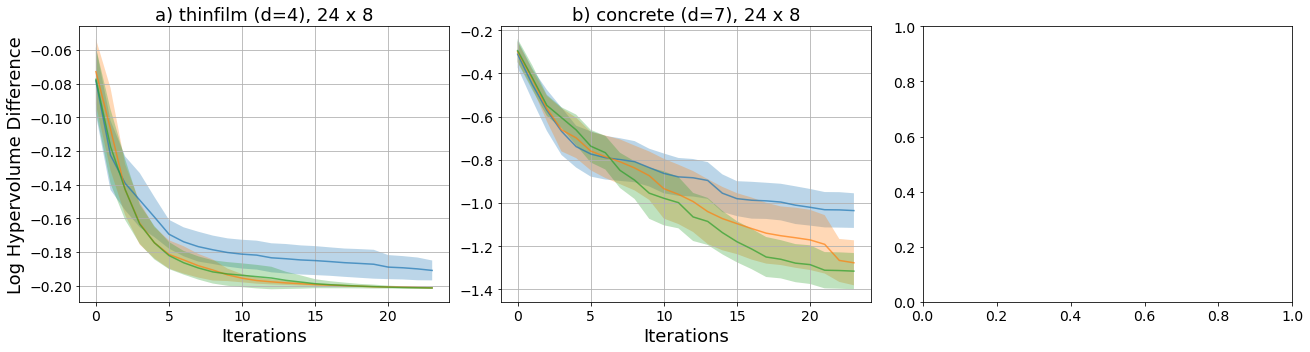

In [9]:
N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 10

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for problemname, max_hv, idx, sub, dim, in zip(
    ['thinfilm', 'concrete'],
    [1.2048935476544, 1.3651840855899149,],
    [0, 1,],
    ['a', 'b',],
    [4, 7]):

    for algo_name, plot_name in zip(
        ['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
        ['Pure BO', 'Hybrid w/ NSGA', 'Hybrid w/ MOEAD']):

        hv_list = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
        hv_plot = np.log10(max_hv - np.asarray(hv_list))

        ax[idx].plot(np.arange(N_BATCH),
                hv_plot.mean(axis=0),
                label=f'{plot_name}', linewidth=1.5, alpha=0.7)

        ax[idx].fill_between(np.arange(N_BATCH),
                        hv_plot.mean(axis=0)-ci(hv_plot, N_TRIALS), hv_plot.mean(axis=0)+ci(hv_plot, N_TRIALS),
                        alpha=0.3)
    
        ax[idx].set(xlabel='Iterations')
        ax[idx].grid(True)
        ax[idx].set_title(f"{sub}) {problemname} (d={dim}), {N_BATCH} x {BATCH_SIZE}", fontsize=18)

fig.tight_layout()        
ax[0].set(ylabel='Log Hypervolume Difference')
#ax.legend(loc='lower left')

In [9]:
import joblib

pareto_y = loadtxt("concrete_pareto.csv", delimiter=',')
yscaler = joblib.load('concrete_yscaler')

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Text(0.5, 1.0, 'PDF')

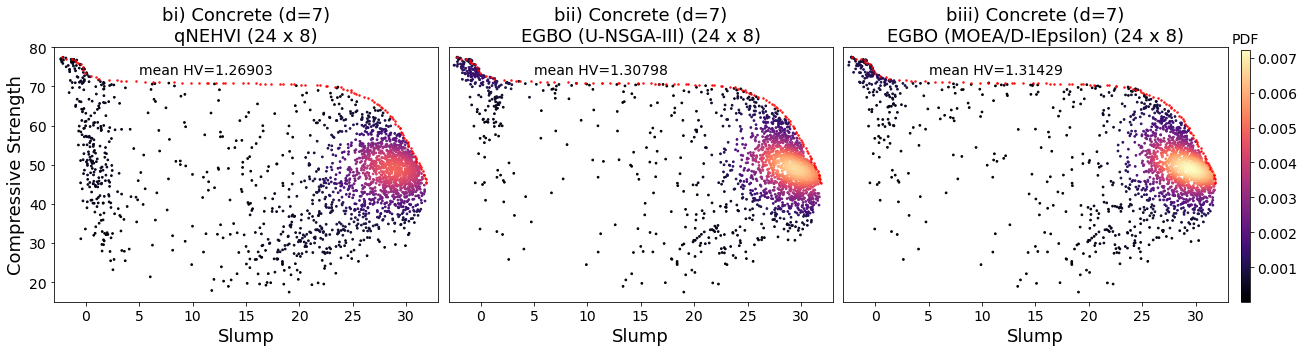

In [10]:
problemname = "concrete"
problem = Problem_concrete

N_TRIALS = 10
N_BATCH = 24
BATCH_SIZE = 8

hv_list, x_list, y_list, z_list = [], [], [], []

for algo_name in (['qnehvi', 'hybrid_nsga', 'hybrid_moead']):
    
    hv = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_list.append(hv)
    
    train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS * (N_BATCH*BATCH_SIZE + 2*(problem.n_var+1)), problem.n_var+problem.n_obj)
    train = yscaler.inverse_transform(train[...][...,-2:])

    
    xy = np.vstack([train[:,0],train[:,1]])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = train[:,0][idx], train[:,1][idx], z[idx]    
    
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)
    
fig, ax = plt.subplots(ncols = 3, figsize = (18,5))

norm = plt.Normalize(np.array(z_list).min(), np.array(z_list).max())

for plot_name, i, subsub in zip(
    ['qNEHVI', 'EGBO (U-NSGA-III)', 'EGBO (MOEA/D-IEpsilon)'],
    [0, 1, 2],
    ['i', 'ii', 'iii']
    ):
    
    ax[i].scatter(x_list[i], y_list[i], c=z_list[i], s=3, norm=norm, cmap='magma')

    ax[i].scatter(pareto_y[:,0],
                  pareto_y[:,1], 
                  c="r", s=10, marker=".", alpha=0.8)    

    ax[i].text(5, 73, f"mean HV={hv_list[i].mean(axis=0)[-1]:.5f}", fontsize=14)

    ax[i].set_title(f"b{subsub}) Concrete (d=7)\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)

    ax[i].set_xlim(-3, 33)
    ax[i].set_ylim(15, 80)
    
    ax[i].set_xlabel('Slump')
    ax[i].tick_params(axis='y', which='both', left=False, labelleft=False)

 

ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)
ax[0].set_ylabel('Compressive Strength')

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)

In [12]:
import joblib

xscaler = joblib.load('thinfilm_xscaler')
yscaler = joblib.load('thinfilm_yscaler')
    
pareto_y1 = loadtxt("thinfilm_pareto1.csv", delimiter=',')
pareto_y2 = loadtxt("thinfilm_pareto2.csv", delimiter=',')  

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Text(0.5, 1.0, 'PDF')

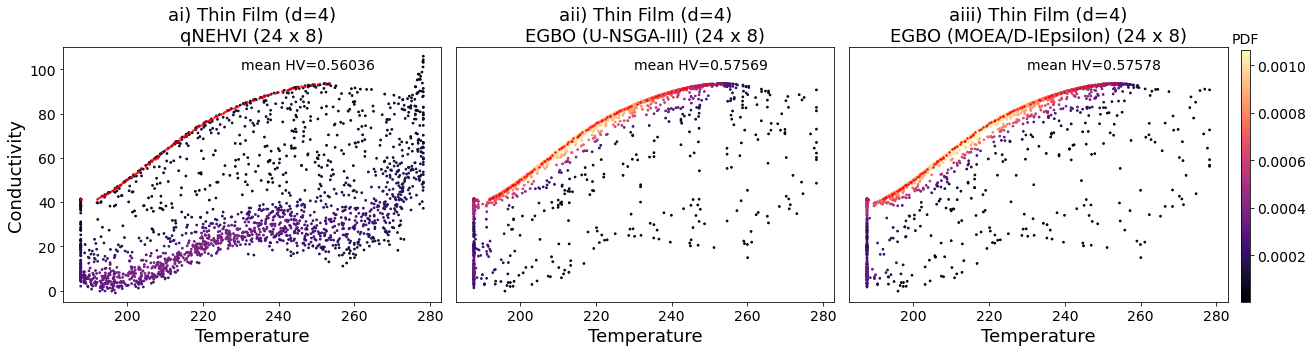

In [14]:
problemname = "thinfilm"
problem = Problem_thinfilm

N_TRIALS = 10
N_BATCH = 24
BATCH_SIZE = 8

hv_list, x_list, y_list, z_list = [], [], [], []

for algo_name in (['qnehvi', 'hybrid_nsga', 'hybrid_moead']):
    
    hv = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_list.append(hv)
    
    train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS * (N_BATCH*BATCH_SIZE + 2*(problem.n_var+1)), problem.n_var+problem.n_obj)
    
    x_true = xscaler.inverse_transform(train[...,0:4])[...,-1]
    y_true = yscaler.inverse_transform(train[...,-1:]).ravel()
    xy = np.vstack([x_true,y_true])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x_true[idx], y_true[idx], z[idx]
 
    
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)
    
fig, ax = plt.subplots(ncols = 3, figsize = (18,5))

norm = plt.Normalize(np.array(z_list).min(), np.array(z_list).max())

for plot_name, i, subsub in zip(
    ['qNEHVI', 'EGBO (U-NSGA-III)', 'EGBO (MOEA/D-IEpsilon)'],
    [0, 1, 2],
    ['i', 'ii', 'iii']
    ):
    
    ax[i].scatter(x_list[i], y_list[i], c=z_list[i], s=3, norm=norm, cmap='magma')

    ax[i].scatter(pareto_y1,
                  pareto_y2, 
                  c="r", s=10, marker=".", alpha=0.8)    

    ax[i].text(230, 100, f"mean HV={hv_list[i].mean(axis=0)[-1]:.5f}", fontsize=14)

    ax[i].set_title(f"a{subsub}) Thin Film (d={dimensions})\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)

    ax[i].set_xlim(183, 283)
    ax[i].set_ylim(-5, 110)
    
    ax[i].set_xlabel('Temperature')
    ax[i].tick_params(axis='y', which='both', left=False, labelleft=False)

 

ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)
ax[0].set_ylabel('Conductivity')

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)

In [6]:
from pymoo.problems import get_problem

ref_point = torch.tensor([11,11], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation

problem = get_problem("zdt1")
volume = hv.compute(torch.tensor(-problem.pareto_front(n_pareto_points=1000), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [11, 11], ZDT1 has a max HV of {volume}")

problem = get_problem("zdt2")
volume = hv.compute(torch.tensor(-problem.pareto_front(n_pareto_points=1000), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [11, 11], ZDT2 has a max HV of {volume}")

problem = get_problem("zdt3")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [11, 11], ZDT3 has a max HV of {volume}")

ref_point = torch.tensor([1.1,1.1], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw3")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.1, 1.1], MW3 has a max HV of {volume}")

ref_point = torch.tensor([1.2,1.2], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw5")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.2, 1.2], MW5 has a max HV of {volume}")

ref_point = torch.tensor([1.2,1.2], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw7")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.2, 1.2], MW7 has a max HV of {volume}")

Using pymoo's Pareto set with reference point of [11, 11], ZDT1 has a max HV of 120.66615962410339
Using pymoo's Pareto set with reference point of [11, 11], ZDT2 has a max HV of 120.33283299983334
Using pymoo's Pareto set with reference point of [11, 11], ZDT3 has a max HV of 128.77549696900383
Using pymoo's Pareto set with reference point of [1.1, 1.1], MW3 has a max HV of 0.6607563181459482
Using pymoo's Pareto set with reference point of [1.2, 1.2], MW5 has a max HV of 0.6229275708817372
Using pymoo's Pareto set with reference point of [1.2, 1.2], MW7 has a max HV of 0.5039622081235824


[Text(117.0, 0.5, 'Log Hypervolume Difference')]

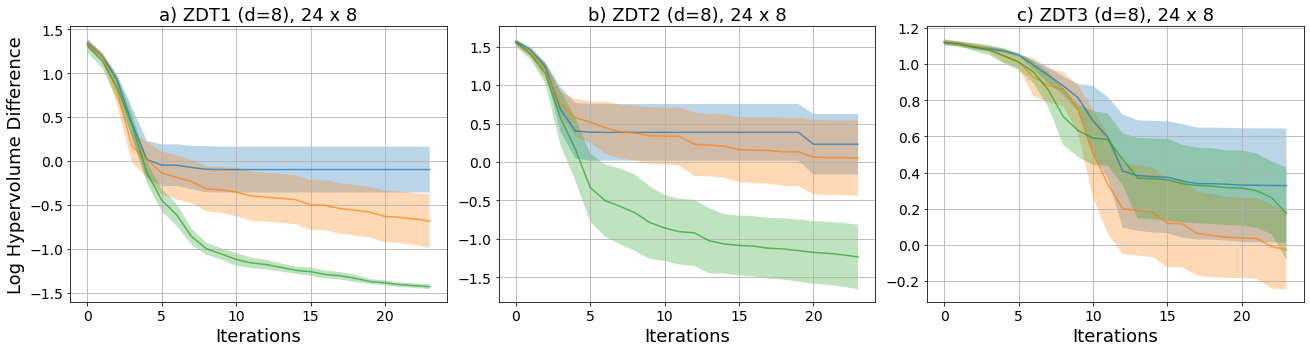

C:\Users\lowki\AppData\Local\Temp\ipykernel_18936\630603469.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_legend.show()


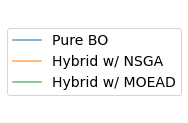

In [8]:
handles,labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(2,2))
axi = fig_legend.add_subplot(111)            
fig_legend.legend(handles, labels, loc='center', scatterpoints = 1)
axi.xaxis.set_visible(False)
axi.yaxis.set_visible(False)
axi.axis("off")
fig_legend.canvas.draw()
fig_legend.show()

In [10]:
N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 10

ref_point = problem.ref_point
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation

basedict = {}
a = 0
b = 2*(problem.n_var+1)-1
for i in range(0, N_BATCH+1):

    basedict[i] = (a, b)
    # a stays at zero
    b+=BATCH_SIZE
    
newdict = {}
a = 2*(problem.n_var+1)
b = 2*(problem.n_var+1)+BATCH_SIZE-1
for i in range(0, N_BATCH):

    newdict[i] = (a, b)
    a+=BATCH_SIZE
    b+=BATCH_SIZE
    
    
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for problem, problemname, idx in zip(
    [Problem_ZDT1, Problem_ZDT2, Problem_ZDT3],
    ['ZDT1', 'ZDT2', 'ZDT3'],
    [0, 1, 2]):

    for algo_name, plot_name, in zip(
        ['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
        ['Pure BO', 'Hybrid w/ NSGA', 'Hybrid w/ MOEAD']):

        train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
        train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj)

        hv_diff_list = []

        for trial in range(0, N_TRIALS):
            train_obj = torch.tensor(-train[trial][:,-problem.n_obj:], **tkwargs)
            hv_diff_inner_list = []

            placeholder = 0

            for i in range(0, N_BATCH):

                base_obj = train_obj[basedict[i][0]:basedict[i][1]]
                pareto_mask = is_non_dominated(base_obj)
                pareto_y = base_obj[pareto_mask]
                base_volume = hv.compute(pareto_y)

                new_obj = train_obj[newdict[i][0]:newdict[i][1]]
                pareto_mask = is_non_dominated(new_obj)
                pareto_y = new_obj[pareto_mask]
                new_volume = hv.compute(pareto_y) 

                hv_diff = base_volume - new_volume

                if hv_diff > 0:
                    placeholder += hv_diff
                    hv_diff_inner_list.append(placeholder)
                else:
                    hv_diff_inner_list.append(placeholder) 

            hv_diff_list.append(hv_diff_inner_list)

        hv_diff_plot = np.asarray(hv_diff_list)

        ax[idx].plot(np.arange(N_BATCH),
                hv_diff_plot.mean(axis=0),
                label=f'{plot_name}', linewidth=1.5, alpha=0.7)

        ax[idx].fill_between(np.arange(N_BATCH),
                        hv_diff_plot.mean(axis=0)-ci(hv_diff_plot, N_TRIALS), hv_diff_plot.mean(axis=0)+ci(hv_diff_plot, N_TRIALS),
                        alpha=0.3)
    
        ax[idx].set(xlabel='Iterations')
        ax[idx].grid(True)
        ax[idx].set_title(f"{problemname} (d=8)", fontsize=18)

fig.tight_layout()                
ax[0].set(ylabel='Cumltv Hypervolume Wastage')
#ax.legend(loc='upper left')

AttributeError: 'MW7' object has no attribute 'ref_point'

Text(0.5, 1.0, 'PDF')

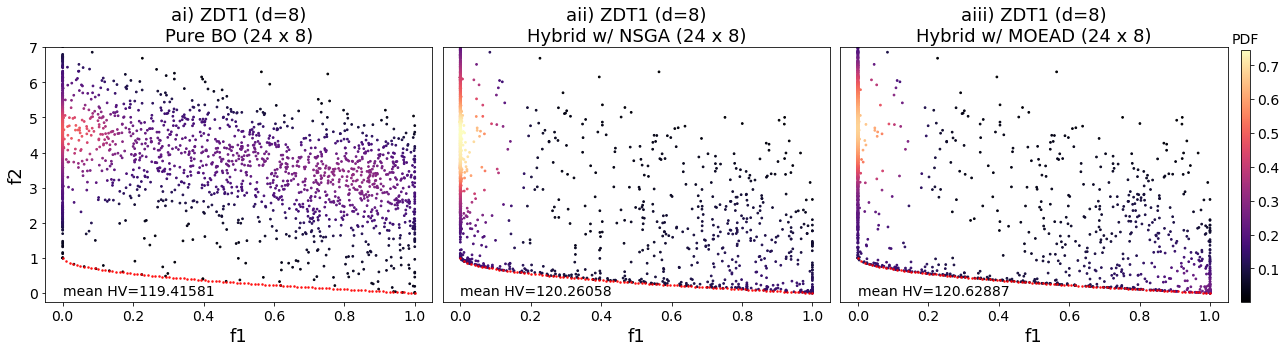

In [22]:
problemname = "ZDT1"
problem = Problem_ZDT1
problem1 = get_problem("zdt1")
pareto = problem1.pareto_front()    

N_TRIALS = 10
N_BATCH = 24
BATCH_SIZE = 8

hv_list, x_list, y_list, z_list = [], [], [], []

for algo_name in (['qnehvi', 'hybrid_nsga', 'hybrid_moead']):
    
    hv = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_list.append(hv)
    
    train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj)
    
    xlist, ylist = [], []

    for trial in range(N_TRIALS):

        xlist.append(-train[trial][:,problem.n_var:problem.n_var+problem.n_obj][:,0])
        ylist.append(-train[trial][:,problem.n_var:problem.n_var+problem.n_obj][:,1])

    x = np.array(xlist).reshape(-1)
    y = np.array(ylist).reshape(-1)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)
    
fig, ax = plt.subplots(ncols = 3, figsize = (18,5))

norm = plt.Normalize(np.array(z_list).min(), np.array(z_list).max())

for plot_name, i, subsub in zip(
    ['Pure BO', 'Hybrid w/ NSGA', 'Hybrid w/ MOEAD'],
    [0, 1, 2],
    ['i', 'ii', 'iii']):
    
    ax[i].scatter(x_list[i], y_list[i], c=z_list[i], s=3, norm=norm, cmap='magma')

    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=10, marker=".", alpha=0.8)    

    ax[i].text(-0.0, -0.05, f"mean HV={hv_list[i].mean(axis=0)[-1]:.5f}", fontsize=14)

    ax[i].set_title(f"a{subsub}) {problemname} (d={dimensions})\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)

    ax[i].set_xlim(-0.05, 1.05)
    ax[i].set_ylim(-0.25, 7.00)
    
    ax[i].set_xlabel('f1')
    ax[i].tick_params(axis='y', which='both', left=False, labelleft=False)

 

ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)
ax[0].set_ylabel('f2')

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)